The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6


# Stochastic Gradient Descent

:label:`sec_sgd`


In this section, we are going to introduce the basic principles of stochastic gradient descent.

In [1]:
%matplotlib inline
import d2l
import math
from mxnet import np, npx
npx.set_np()

## Stochastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset. We assume that $f_i(\mathbf{x})$ is the loss function of the training data instance with $n$ examples, an index of $i$, and parameter vector of $\mathbf{x}$, then we have the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computing cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the model training data instance is large, the cost of gradient descent for each iteration will be very high.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data instances at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}).$$

Here, $\eta$ is the learning rate. We can see that the computing cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. We should mention that the stochastic gradient $\nabla f_i(\mathbf{x})$ is the unbiased estimate of gradient $\nabla f(\mathbf{x})$.

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it to gradient descent by adding random noise with a mean of 0 to the gradient to simulate a SGD.

epoch 1, x1 -4.231221, x2 -1.287400
epoch 2, x1 -3.499321, x2 -0.900833
epoch 3, x1 -2.998628, x2 -0.427026
epoch 4, x1 -2.231799, x2 -0.221077
epoch 5, x1 -1.853378, x2 0.042962
epoch 6, x1 -1.295014, x2 0.036579
epoch 7, x1 -1.070454, x2 0.015664
epoch 8, x1 -0.817588, x2 0.001660
epoch 9, x1 -0.721532, x2 -0.155617
epoch 10, x1 -0.655854, x2 -0.138866
epoch 11, x1 -0.642000, x2 -0.105337
epoch 12, x1 -0.426489, x2 0.004367
epoch 13, x1 -0.272370, x2 -0.081557
epoch 14, x1 -0.080551, x2 0.048375
epoch 15, x1 0.029807, x2 0.151814
epoch 16, x1 0.161342, x2 0.133502
epoch 17, x1 -0.007552, x2 -0.019405
epoch 18, x1 0.044118, x2 -0.142049
epoch 19, x1 0.122416, x2 -0.036973
epoch 20, x1 0.050762, x2 -0.125184
epoch 21, x1 0.172867, x2 -0.033349
epoch 22, x1 -0.072589, x2 -0.058640
epoch 23, x1 -0.124117, x2 -0.142160
epoch 24, x1 -0.056440, x2 0.093613
epoch 25, x1 -0.120631, x2 0.091649
epoch 26, x1 -0.139016, x2 0.175013
epoch 27, x1 -0.158006, x2 -0.050335
epoch 28, x1 -0.160559, x2 

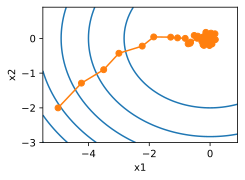

In [2]:
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2  # Objective

def gradf(x1, x2):
    return (2 * x1, 4 * x2)  # Gradient

def sgd(x1, x2, s1, s2):  # Simulate noisy gradient
    global lr  # Learning rate scheduler
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    (g1, g2) = (g1 + np.random.normal(0.1), g2 + np.random.normal(0.1))
    eta_t = eta * lr()  # Learning rate at time t
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)  # Update variables

eta = 0.1
lr = (lambda: 1)  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

As we can see, the trajectory of the variables in the SGD is much more noisy than the one we observed in gradient descent in the previous section. This is due to the stochastic nature of the gradient. That is, even when we arrive near the minimum, we are still subject to the uncertainty injected by the instantaneous gradient via $\eta \nabla f_i(\mathbf{x})$. Even after 50 steps the quality is still not so good. Even worse, it will not improve after additional steps (we encourage the reader to experiment with a larger number of steps to confirm this on his own). This leaves us with the only alternative---change the learning rate $\eta$. However, if we pick this too small, we will not make any meaningful progress initially. On the other hand, if we pick it too large, we will not get a good solution, as seen above. The only way to resolve these conflicting goals is to reduce the learning rate *dynamically* as optimization progresses.

This is also the reason for adding a learning rate function `lr` into the `sgd` step function. In the example above any functionality for learning rate scheduling lies dormant as we set the associated `lr` function to be constant, i.e., `lr = (lambda: 1)`.

## Dynamic Learning Rate

Replacing $\eta$ with a time-dependent learning rate $\eta(t)$ adds to the complexity of controlling convergence of an optimization algorithm. In particular, need to figure out how rapidly $\eta$ should decay. If it is too quick, we will stop optimizing prematurely. If we decrease it too slowly, we waste too much time on optimization. There are a few basic strategies that are used in adjusting $\eta$ over time (we will discuss more advanced strategies in a later chapter):

$$
\begin{aligned}
    \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \mathrm{piecewise~constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \mathrm{exponential} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \mathrm{polynomial}
\end{aligned}
$$

In the first scenario we decrease the learning rate, e.g., whenever progress in optimization has stalled. This is a common strategy for training deep networks. Alternatively we could decrease it much more aggressively by an exponential decay. Unfortunately this leads to premature stopping before the algorithm has converged. A popular choice is polynomial decay with $\alpha = 0.5$. In the case of convex optimization there are a number of proofs which show that this rate is well behaved. Let us see what this looks like in practice.

epoch 1, x1 -4.187498, x2 -1.441271
epoch 2, x1 -3.480476, x2 -0.959998
epoch 3, x1 -3.114053, x2 -0.776623
epoch 4, x1 -2.708901, x2 -0.478098
epoch 5, x1 -2.485057, x2 -0.352735
epoch 6, x1 -2.254137, x2 -0.221854
epoch 7, x1 -1.991054, x2 -0.151798
epoch 8, x1 -1.845638, x2 -0.118831
epoch 9, x1 -1.719661, x2 -0.088086
epoch 10, x1 -1.600937, x2 -0.071031
epoch 11, x1 -1.508440, x2 -0.031854
epoch 12, x1 -1.437246, x2 -0.021014
epoch 13, x1 -1.341845, x2 -0.010659
epoch 14, x1 -1.263227, x2 0.038187
epoch 15, x1 -1.207312, x2 0.041305
epoch 16, x1 -1.174320, x2 0.019743
epoch 17, x1 -1.129022, x2 0.042506
epoch 18, x1 -1.094389, x2 0.046345
epoch 19, x1 -1.063700, x2 0.036641
epoch 20, x1 -1.044599, x2 0.031504
epoch 21, x1 -1.030997, x2 0.028999
epoch 22, x1 -1.006169, x2 0.009590
epoch 23, x1 -0.987778, x2 -0.005833
epoch 24, x1 -0.981508, x2 -0.018722
epoch 25, x1 -0.971658, x2 -0.009066
epoch 26, x1 -0.954919, x2 -0.005784
epoch 27, x1 -0.944525, x2 -0.004234
epoch 28, x1 -0.937

epoch 217, x1 -0.862200, x2 -0.019736
epoch 218, x1 -0.862200, x2 -0.019736
epoch 219, x1 -0.862200, x2 -0.019736
epoch 220, x1 -0.862200, x2 -0.019736
epoch 221, x1 -0.862200, x2 -0.019736
epoch 222, x1 -0.862200, x2 -0.019736
epoch 223, x1 -0.862200, x2 -0.019736
epoch 224, x1 -0.862200, x2 -0.019736
epoch 225, x1 -0.862200, x2 -0.019736
epoch 226, x1 -0.862200, x2 -0.019736
epoch 227, x1 -0.862200, x2 -0.019736
epoch 228, x1 -0.862200, x2 -0.019736
epoch 229, x1 -0.862200, x2 -0.019736
epoch 230, x1 -0.862200, x2 -0.019736
epoch 231, x1 -0.862200, x2 -0.019736
epoch 232, x1 -0.862200, x2 -0.019736
epoch 233, x1 -0.862200, x2 -0.019736
epoch 234, x1 -0.862200, x2 -0.019736
epoch 235, x1 -0.862200, x2 -0.019736
epoch 236, x1 -0.862200, x2 -0.019736
epoch 237, x1 -0.862200, x2 -0.019736
epoch 238, x1 -0.862200, x2 -0.019736
epoch 239, x1 -0.862200, x2 -0.019736
epoch 240, x1 -0.862200, x2 -0.019736
epoch 241, x1 -0.862200, x2 -0.019736
epoch 242, x1 -0.862200, x2 -0.019736
epoch 243, x

epoch 425, x1 -0.862200, x2 -0.019736
epoch 426, x1 -0.862200, x2 -0.019736
epoch 427, x1 -0.862200, x2 -0.019736
epoch 428, x1 -0.862200, x2 -0.019736
epoch 429, x1 -0.862200, x2 -0.019736
epoch 430, x1 -0.862200, x2 -0.019736
epoch 431, x1 -0.862200, x2 -0.019736
epoch 432, x1 -0.862200, x2 -0.019736
epoch 433, x1 -0.862200, x2 -0.019736
epoch 434, x1 -0.862200, x2 -0.019736
epoch 435, x1 -0.862200, x2 -0.019736
epoch 436, x1 -0.862200, x2 -0.019736
epoch 437, x1 -0.862200, x2 -0.019736
epoch 438, x1 -0.862200, x2 -0.019736
epoch 439, x1 -0.862200, x2 -0.019736
epoch 440, x1 -0.862200, x2 -0.019736
epoch 441, x1 -0.862200, x2 -0.019736
epoch 442, x1 -0.862200, x2 -0.019736
epoch 443, x1 -0.862200, x2 -0.019736
epoch 444, x1 -0.862200, x2 -0.019736
epoch 445, x1 -0.862200, x2 -0.019736
epoch 446, x1 -0.862200, x2 -0.019736
epoch 447, x1 -0.862200, x2 -0.019736
epoch 448, x1 -0.862200, x2 -0.019736
epoch 449, x1 -0.862200, x2 -0.019736
epoch 450, x1 -0.862200, x2 -0.019736
epoch 451, x

epoch 635, x1 -0.862200, x2 -0.019736
epoch 636, x1 -0.862200, x2 -0.019736
epoch 637, x1 -0.862200, x2 -0.019736
epoch 638, x1 -0.862200, x2 -0.019736
epoch 639, x1 -0.862200, x2 -0.019736
epoch 640, x1 -0.862200, x2 -0.019736
epoch 641, x1 -0.862200, x2 -0.019736
epoch 642, x1 -0.862200, x2 -0.019736
epoch 643, x1 -0.862200, x2 -0.019736
epoch 644, x1 -0.862200, x2 -0.019736
epoch 645, x1 -0.862200, x2 -0.019736
epoch 646, x1 -0.862200, x2 -0.019736
epoch 647, x1 -0.862200, x2 -0.019736
epoch 648, x1 -0.862200, x2 -0.019736
epoch 649, x1 -0.862200, x2 -0.019736
epoch 650, x1 -0.862200, x2 -0.019736
epoch 651, x1 -0.862200, x2 -0.019736
epoch 652, x1 -0.862200, x2 -0.019736
epoch 653, x1 -0.862200, x2 -0.019736
epoch 654, x1 -0.862200, x2 -0.019736
epoch 655, x1 -0.862200, x2 -0.019736
epoch 656, x1 -0.862200, x2 -0.019736
epoch 657, x1 -0.862200, x2 -0.019736
epoch 658, x1 -0.862200, x2 -0.019736
epoch 659, x1 -0.862200, x2 -0.019736
epoch 660, x1 -0.862200, x2 -0.019736
epoch 661, x

epoch 798, x1 -0.862200, x2 -0.019736
epoch 799, x1 -0.862200, x2 -0.019736
epoch 800, x1 -0.862200, x2 -0.019736
epoch 801, x1 -0.862200, x2 -0.019736
epoch 802, x1 -0.862200, x2 -0.019736
epoch 803, x1 -0.862200, x2 -0.019736
epoch 804, x1 -0.862200, x2 -0.019736
epoch 805, x1 -0.862200, x2 -0.019736
epoch 806, x1 -0.862200, x2 -0.019736
epoch 807, x1 -0.862200, x2 -0.019736
epoch 808, x1 -0.862200, x2 -0.019736
epoch 809, x1 -0.862200, x2 -0.019736
epoch 810, x1 -0.862200, x2 -0.019736
epoch 811, x1 -0.862200, x2 -0.019736
epoch 812, x1 -0.862200, x2 -0.019736
epoch 813, x1 -0.862200, x2 -0.019736
epoch 814, x1 -0.862200, x2 -0.019736
epoch 815, x1 -0.862200, x2 -0.019736
epoch 816, x1 -0.862200, x2 -0.019736
epoch 817, x1 -0.862200, x2 -0.019736
epoch 818, x1 -0.862200, x2 -0.019736
epoch 819, x1 -0.862200, x2 -0.019736
epoch 820, x1 -0.862200, x2 -0.019736
epoch 821, x1 -0.862200, x2 -0.019736
epoch 822, x1 -0.862200, x2 -0.019736
epoch 823, x1 -0.862200, x2 -0.019736
epoch 824, x

epoch 952, x1 -0.862200, x2 -0.019736
epoch 953, x1 -0.862200, x2 -0.019736
epoch 954, x1 -0.862200, x2 -0.019736
epoch 955, x1 -0.862200, x2 -0.019736
epoch 956, x1 -0.862200, x2 -0.019736
epoch 957, x1 -0.862200, x2 -0.019736
epoch 958, x1 -0.862200, x2 -0.019736
epoch 959, x1 -0.862200, x2 -0.019736
epoch 960, x1 -0.862200, x2 -0.019736
epoch 961, x1 -0.862200, x2 -0.019736
epoch 962, x1 -0.862200, x2 -0.019736
epoch 963, x1 -0.862200, x2 -0.019736
epoch 964, x1 -0.862200, x2 -0.019736
epoch 965, x1 -0.862200, x2 -0.019736
epoch 966, x1 -0.862200, x2 -0.019736
epoch 967, x1 -0.862200, x2 -0.019736
epoch 968, x1 -0.862200, x2 -0.019736
epoch 969, x1 -0.862200, x2 -0.019736
epoch 970, x1 -0.862200, x2 -0.019736
epoch 971, x1 -0.862200, x2 -0.019736
epoch 972, x1 -0.862200, x2 -0.019736
epoch 973, x1 -0.862200, x2 -0.019736
epoch 974, x1 -0.862200, x2 -0.019736
epoch 975, x1 -0.862200, x2 -0.019736
epoch 976, x1 -0.862200, x2 -0.019736
epoch 977, x1 -0.862200, x2 -0.019736
epoch 978, x

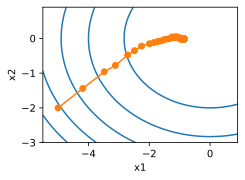

In [3]:
def exponential():
    global ctr
    ctr += 1
    return math.exp(-0.1 * ctr)

ctr = 1
lr = exponential  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000))

As expected, the variance in the parameters is significantly reduced. However, this comes at the expense of failing to converge to the optimal solution $\mathbf{x} = (0, 0)$. Even after 1000 steps are we are still very far away from the optimal solution. Indeed, the algorithm fails to converge at all. On the other hand, if we use a polynomial decay where the learning rate decays with the inverse square root of the number of steps convergence is good.

epoch 1, x1 -4.117116, x2 -1.264984
epoch 2, x1 -3.393946, x2 -0.943845
epoch 3, x1 -2.625807, x2 -0.468526
epoch 4, x1 -2.116790, x2 -0.212297
epoch 5, x1 -1.683528, x2 -0.114543
epoch 6, x1 -1.532377, x2 -0.168514
epoch 7, x1 -1.363571, x2 -0.001855
epoch 8, x1 -1.080831, x2 -0.058512
epoch 9, x1 -0.889631, x2 -0.049189
epoch 10, x1 -0.740804, x2 -0.086510
epoch 11, x1 -0.582573, x2 -0.129555
epoch 12, x1 -0.557373, x2 -0.101391
epoch 13, x1 -0.498110, x2 -0.032276
epoch 14, x1 -0.403853, x2 -0.107747
epoch 15, x1 -0.284433, x2 -0.160354
epoch 16, x1 -0.304945, x2 -0.006315
epoch 17, x1 -0.322509, x2 -0.051712
epoch 18, x1 -0.224754, x2 0.017035
epoch 19, x1 -0.193038, x2 -0.005604
epoch 20, x1 -0.150690, x2 -0.029124
epoch 21, x1 -0.083835, x2 -0.030703
epoch 22, x1 0.022822, x2 -0.039436
epoch 23, x1 -0.027158, x2 -0.125483
epoch 24, x1 -0.063541, x2 -0.192071
epoch 25, x1 -0.063003, x2 -0.132565
epoch 26, x1 -0.024215, x2 -0.173649
epoch 27, x1 -0.030869, x2 -0.149434
epoch 28, x1

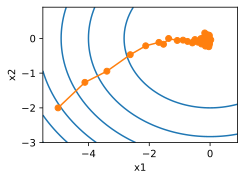

In [4]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr = 1
lr = polynomial  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

There exist many more choices for how to set the learning rate. For instance, we could start with a small rate, then rapidly ramp up and then decrease it again, albeit more slowly. We could even alternate between smaller and larger learning rates. There exists a large variety of such schedules. For now let us focus on learning rate schedules for which a comprehensive theoretical analysis is possible, i.e., on learning rates in a convex setting. For general nonconvex problems it is very difficult to obtain meaningful convergence guarantees, since in general minimizing nonlinear nonconvex problems is NP hard. For a survey see e.g., the excellent [lecture notes](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf) of Tibshirani 2015.

## Convergence Analysis for Convex Objectives

The following is optional and primarily serves to convey more intuition about the problem. We limit ourselves to one of the simplest proofs, as described by :cite:`Nesterov.Vial.2000`. Significantly more advanced proof techniques exist, e.g., whenever the objective function is particularly well behaved. :cite:`Hazan.Rakhlin.Bartlett.2008` show that for strongly convex functions, i.e., for functions that can be bounded from below by $\mathbf{x}^\top \mathbf{Q} \mathbf{x}$, it is possible to minimize them in a small number of steps while decreasing the learning rate like $\eta(t) = \eta_0/(\beta t + 1)$. Unfortunately this case never really occurs in deep learning and we are left with a much more slowly decreasing rate in practice.

Consider the case where
$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta_t \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w}).$$

In particular, assume that $\mathbf{x}_t$ is drawn from some distribution $P(\mathbf{x})$ and that $l(\mathbf{x}, \mathbf{w})$ is a convex function in $\mathbf{w}$ for all $\mathbf{x}$. Last denote by

$$R(\mathbf{w}) = E_{\mathbf{x} \sim P}[l(\mathbf{x}, \mathbf{w})]$$

the expected risk and by $R^*$ its minimum with regard to $\mathbf{w}$. Last let $\mathbf{w}^*$ be the minimizer (we assume that it exists within the domain which $\mathbf{w}$ is defined). In this case we can track the distance between the current parameter $\mathbf{w}_t$ and the risk minimizer $\mathbf{w}^*$ and see whether it improves over time:

$$\begin{aligned}
    \|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2 & = \|\mathbf{w}_{t} - \eta_t \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w}) - \mathbf{w}^*\|^2 \\
    & = \|\mathbf{w}_{t} - \mathbf{w}^*\|^2 + \eta_t^2 \|\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\|^2 - 2 \eta_t
    \left\langle \mathbf{w}_t - \mathbf{w}^*, \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\right\rangle.
   \end{aligned}
$$

The gradient $\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})$ can be bounded from above by some Lipschitz constant $L$, hence we have that

$$\eta_t^2 \|\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\|^2 \leq \eta_t^2 L^2.$$

We are mostly interested in how the distance between $\mathbf{w}_t$ and $\mathbf{w}^*$ changes *in expectation*. In fact, for any specific sequence of steps the distance might well increase, depending on whichever $\mathbf{x}_t$ we encounter. Hence we need to bound the inner product. By convexity we have that

$$
l(\mathbf{x}_t, \mathbf{w}^*) \geq l(\mathbf{x}_t, \mathbf{w}_t) + \left\langle \mathbf{w}^* - \mathbf{w}_t, \partial_{\mathbf{w}} l(\mathbf{x}_t, \mathbf{w}_t) \right\rangle.
$$

Using both inequalities and plugging it into the above we obtain a bound on the distance between parameters at time $t+1$ as follows:

$$\|\mathbf{w}_{t} - \mathbf{w}^*\|^2 - \|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2 \geq 2 \eta_t (l(\mathbf{x}_t, \mathbf{w}_t) - l(\mathbf{x}_t, \mathbf{w}^*)) - \eta_t^2 L^2.$$

This means that we make progress as long as the expected difference between current loss and the optimal loss outweighs $\eta_t L^2$. Since the former is bound to converge to $0$ it follows that the learning rate $\eta_t$ also needs to vanish.

Next we take expectations over this expression. This yields

$$E_{\mathbf{w}_t}\left[\|\mathbf{w}_{t} - \mathbf{w}^*\|^2\right] - E_{\mathbf{w}_{t+1}\mid \mathbf{w}_t}\left[\|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2\right] \geq 2 \eta_t [E[R[\mathbf{w}_t]] - R^*] -  \eta_t^2 L^2.$$

The last step involves summing over the inequalities for $t \in \{t, \ldots, T\}$. Since the sum telescopes and by dropping the lower term we obtain

$$\|\mathbf{w}_{0} - \mathbf{w}^*\|^2 \geq 2 \sum_{t=1}^T \eta_t [E[R[\mathbf{w}_t]] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.$$

Note that we exploited that $\mathbf{w}_0$ is given and thus the expectation can be dropped. Last define

$$\bar{\mathbf{w}} := \frac{\sum_{t=1}^T \eta_t \mathbf{w}_t}{\sum_{t=1}^T \eta_t}.$$

Then by convexity it follows that

$$\sum_t \eta_t E[R[\mathbf{w}_t]] \geq \sum \eta_t \cdot \left[E[\bar{\mathbf{w}}]\right].$$

Plugging this into the above inequality yields the bound

$$
\left[E[\bar{\mathbf{w}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t}.
$$

Here $r^2 := \|\mathbf{w}_0 - \mathbf{w}^*\|^2$ is a bound on the distance between the initial choice of parameters and the final outcome. In short, the speed of convergence depends on how rapidly the loss function changes via the Lipschitz constant $L$ and how far away from optimality the initial value is $r$. Note that the bound is in terms of $\bar{\mathbf{w}}$ rather than $\mathbf{w}_T$. This is the case since $\bar{\mathbf{w}}$ is a smoothed version of the optimization path. Now let us analyze some choices for $\eta_t$.

* **Known Time Horizon**. Whenever $r, L$ and $T$ are known we can pick $\eta = r/L \sqrt{T}$. This yields as upper bound $r L (1 + 1/T)/2\sqrt{T} < rL/\sqrt{T}$. That is, we converge with rate $\mathcal{O}(1/\sqrt{T})$ to the optimal solution.
* **Unknown Time Horizon**. Whenever we want to have a good solution for *any* time $T$ we can pick $\eta = \mathcal{O}(1/\sqrt{T})$. This costs us an extra logarithmic factor and it leads to an upper bound of the form $\mathcal{O}(\log T / \sqrt{T})$.

Note that for strongly convex losses $l(\mathbf{x}, \mathbf{w}') \geq l(\mathbf{x}, \mathbf{w}) + \langle \mathbf{w}'-\mathbf{w}, \partial_\mathbf{w} l(\mathbf{x}, \mathbf{w}) \rangle + \frac{\lambda}{2} \|\mathbf{w}-\mathbf{w}'\|^2$ we can design even more rapidly converging optimization schedules. In fact, an exponential decay in $\eta$ leads to a bound of the form $\mathcal{O}(\log T / T)$.

## Stochastic Gradients and Finite Samples

So far we have played a bit fast and loose when it comes to talking about stochastic gradient descent. We posited that we draw instances $x_i$, typically with labels $y_i$ from some distribution $p(x, y)$ and that we use this to update the weights $w$ in some manner. In particular, for a finite sample size we simply argued that the discrete distribution $p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$ allows us to perform SGD over it.

However, this is not really what we did. In the toy examples in the current section we simply added noise to an otherwise non-stochastic gradient, i.e., we pretended to have pairs $(x_i, y_i)$. It turns out that this is justified here (see the exercises for a detailed discussion). More troubling is that in all previous discussions we clearly did not do this. Instead we iterated over all instances exactly once. To see why this is preferable consider the converse, namely that we are sampling $n$ observations from the discrete distribution with replacement. The probability of choosing an element $i$ at random is $N^{-1}$. Thus to choose it at least once is

$$P(\mathrm{choose~} i) = 1 - P(\mathrm{omit~} i) = 1 - (1-N^{-1})^N \approx 1-e^{-1} \approx 0.63.$$

A similar reasoning shows that the probability of picking a sample exactly once is given by ${N \choose 1} N^{-1} (1-N^{-1})^{N-1} = \frac{N-1}{N} (1-N^{-1})^{N} \approx e^{-1} \approx 0.37$. This leads to an increased variance and decreased data efficiency relative to sampling without replacement. Hence, in practice we perform the latter (and this is the default choice throughout this book). Last note that repeated passes through the dataset traverse it in a *different* random order.


## Summary

* For convex problems we can prove that for a wide choice of learning rates Stochastic Gradient Descent will converge to the optimal solution.
* For deep learning this is generally not the case. However, the analysis of convex problems gives us useful insight into how to approach optimization, namely to reduce the learning rate progressively, albeit not too quickly.
* Problems occur when the learning rate is too small or too large. In practice  a suitable learning rate is often found only after multiple experiments.
* When there are more examples in the training dataset, it costs more to compute each iteration for gradient descent, so SGD is preferred in these cases.
* Optimality guarantees for SGD are in general not available in nonconvex cases since the number of local minima that require checking might well be exponential.


## Exercises

1. Experiment with different learning rate schedules for SGD and with different numbers of iterations. In particular, plot the distance from the optimal solution $(0, 0)$ as a function of the number of iterations.
1. Prove that for the function $f(x_1, x_2) = x_1^2 + 2 x_2^2$ adding normal noise to the gradient is equivalent to minimizing a loss function $l(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$ where $x$ is drawn from a normal distribution.
    * Derive mean and variance of the distribution for $\mathbf{x}$.
    * Show that this property holds in general for objective functions $f(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{\mu})^\top Q (\mathbf{x} - \mathbf{\mu})$ for $Q \succeq 0$.
1. Compare convergence of SGD when you sample from $\{(x_1, y_1), \ldots, (x_m, y_m)\}$ with replacement and when you sample without replacement.
1. How would you change the SGD solver if some gradient (or rather some coordinate associated with it) was consistently larger than all other gradients?
1. Assume that $f(x) = x^2 (1 + \sin x)$. How many local minima does $f$ have? Can you change $f$ in such a way that to minimize it one needs to evaluate all local minima?

## [Discussions](https://discuss.mxnet.io/t/2372)

![](http://d2l.ai/_images/qr_sgd.svg)